This Python Notebook provides sample code for reading and interpreting Feature_Classification_Flags and the associated spatial and tempral data from a 
CALIPSO LIDAR Level2 Vertical Feature Mask hdf4 data file (CAL_LID_L2_VFM-Standard-V4-20).

This code specifically illustrates the retreival of Volcanic Ash Stratospherice Aerosol Type flag information from the "Feature_Classification_Flags" HDF4 SDS variable.

The following links contain detailed backround information on this science data product.
https://www-calipso.larc.nasa.gov/resources/calipso_users_guide/data_summaries/vfm/index_v420.php
https://www-calipso.larc.nasa.gov/resources/calipso_users_guide/qs/cal_lid_l2_all_v4-20.php

In [6]:
#uncommment and run (if needed) to install packages
#!conda install -c conda-forge astropy --yes
#!conda install -c conda-forge pyhdf --yes
#!conda install -c conda-forge pydap --yes
print('package install complete')

package install complete


In [2]:
import matplotlib.pyplot as plt
from astropy.time import Time
from pyhdf.SD import SD, SDC
import numpy as np

The following plots indicates volcanic ash has been detected near the following latitudes:

11.5-12.5km altitude at ~-59 degrees latitude
https://www-calipso.larc.nasa.gov/data/BROWSE/production/V4-10/2014-02-13/2014-02-13_05-20-10_V4.10_1_9.png

16-17km altitude between -10 to -25 degrees latitude
https://www-calipso.larc.nasa.gov/data/BROWSE/production/V4-10/2014-02-13/2014-02-13_05-20-10_V4.10_2_9.png

28-29km altitude at ~6 degrees latitude
https://www-calipso.larc.nasa.gov/data/BROWSE/production/V4-10/2014-02-13/2014-02-13_05-20-10_V4.10_3_9.png



CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf (original archived hdf4 file with filesize = 49.1MB) has Volcanic Ash observations.  We could access the original granule directly using the following url:
https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2014/02/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf

In [3]:
import requests
import os.path
fname='CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf'
url = 'https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2014/02/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf'

if not os.path.isfile(fname):
    try:
        print("Attempting to download: "+fname+" from the ASDC OPeNDAP service...")
        r = requests.get(url, allow_redirects=True)
        open(fname, 'wb').write(r.content)
        if os.path.isfile(fname):
            print("Success! The full path to the data file is: "+os.path.abspath(fname))
    except Exception as e:
        print("Error: " + str(e))
    
else:
    print('Found '+os.path.abspath(fname)+' on your system.\nSkipping the download process from the ASDC OPeNDAP Service.')


Found /Users/wbaskin/git/test-CALIPSO/bin/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf on your system.
Skipping the download process from the ASDC OPeNDAP Service.


Retrieve Latitude, Longitude, Profile_Time, and Feature_Classification_Flags data arrays from a CAL_LID_L2_VFM-Standard-V4-20 data granule.

In [4]:
#open the hdf4 granule
read_hdf = SD(fname, SDC.READ)

# Read datasets (arrays of data in the hdf4 file)
# Read geolocation datasets.
#selects for latitude
latitude = read_hdf.select('Latitude')
lat = latitude[:]
#selects for longitude
longitude = read_hdf.select('Longitude')
lon= longitude[:]
#selects for profile time(level 2)
profile_Time= read_hdf.select('Profile_Time')
time= profile_Time[:]
#selects for feature classification flags 
feature_classification_flags = read_hdf.select('Feature_Classification_Flags')
flags= feature_classification_flags[:]
print("The shape of the array of the Feature_Classification_Flags HDF4 SDS dataset (dim0, dim1) is:",np.asarray(flags).shape)

The shape of the array of the Feature_Classification_Flags HDF4 SDS dataset (dim0, dim1) is: (4224, 5515)


Identify the locations (array indices) of observation in the feature_classification_flags array that Feature Type flag corresponding to a stratospheric aerosol type, then refine the list of indices to unique dim0 indices of rows containing volcanic ash flag types.

In [5]:
# Extract Feature Type only (1-3 bits) through bitmask.
#feature_type_mask=np.uint16(0b0000000000000111)
#strat_aero=flags&feature_type_mask

#Strat_aero is the first filter to identify volcanic ash, and it is located in bit 2, so (100 binary)  or 4(unsigned integer))
#Find the indices where there is stratospheric aerosol using a numpy command
#strat_aero_indices=np.where(strat_aero==4)

#next step in filtering: volcanic ash
#locating in bit 1 so 10000000000, but to ensure that strat_aero is still being selected, you must do
#10000000100
mask=np.uint16(0b0000010000000100)
#this is the same as the integer value: 1028  (uncomment the print statement below to prove this)
#print("The numeric value of 0b0000010000000100 is: "+str(mask))

volcanic_ash=flags&mask

#create a list of indices in the CAL_LID_L2_VFM-Standard-V4-20 file containing volcanic ash flags
#volcanic_ash_indices=np.where(volcanic_ash==1028)

volcanic_ash_indices=np.where(volcanic_ash==mask)
volcanic_ash_latitudes=np.take(lat, volcanic_ash_indices)
volcanic_ash_longitudes=np.take(lon, volcanic_ash_indices)
volcanic_ash_times=np.take(time, volcanic_ash_indices)

#print("Latitudes of observations with the 'volcanic ash' Feature Classification Flag")
#print(volcanic_ash_latitudes)

#Create a dictionary with keys = dim0 indices and values = list of dim1 indices in Feature_Classification_Flags that have flag values corresponding to the volcanic ash type

#inspired from: https://stackoverflow.com/questions/3783530/python-tuple-to-dict
volcanic_ash_indices_dic = dict()
for y,x in np.asarray(volcanic_ash_indices).transpose():
    if(y in volcanic_ash_indices_dic):
        volcanic_ash_indices_dic[y].append(x)
    else:
        volcanic_ash_indices_dic[y] = [x]      
#executes in 0.0049 ms
keys=list(volcanic_ash_indices_dic.keys())
print("dim0 indices for the 'volcanic ash' Feature Classification Flag: ", keys)
print()
print("dim1 indices for the 'volcanic ash' Feature Classification Flag at dim0 = "+ str(keys[0])+" are: ", volcanic_ash_indices_dic[keys[0]])


##Alternative method produces a Pandas DataFrame with columns dim0 and dim1 conaining indices for the volcanic_ash_keys is ~10x slower than the code above
#import pandas as pd
#start = time.time()
##inspired from: https://stackoverflow.com/questions/23268605/grouping-indices-of-unique-elements-in-numpy
#df = pd.DataFrame(columns={'dim0','dim1'},data=list(np.asarray(volcanic_ash_indices).transpose()))
#gg = df.groupby('dim0').agg({'dim1':lambda x: list(x)})
##executes in 0.0365 ms
#print(gg.head())





dim0 indices for the 'volcanic ash' Feature Classification Flag:  [384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 468, 469, 470, 471, 520, 521, 522, 523, 672, 673, 674, 675, 1004, 1005, 1006, 1007, 1042, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1768, 1769, 1770, 1771, 1788, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1886, 1890, 1891, 1892, 1893, 1897, 2083, 2460, 2461, 2462, 2463, 2509, 3016, 3017, 3018, 3019, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3968, 3969, 3970, 3971]

dim1 indices for the 'volcanic ash' Feature Classification Flag at dim0 = 384 are:  [40, 41, 42, 43, 44, 45, 46, 47, 95, 96, 97, 98, 99, 100, 101, 102, 150, 151, 152, 153, 154, 155, 156, 157]


We have the basic spatial-temporal data associated with dim0 of the Feature_Classification_Flags[dim0][dim1] array from the CAL_LID_L2_VFM-Standard-V4-20 file.  The position of the flags in the second dimension (dim1 of size 5515) of the Feature_Classification_Flags array can be used to determine the altitude and spatial extent the observation.

In [6]:
def st_decode(index):
    #The size of the second dimension of the Feature_Classification_Flags array is 5515 (index range 0 to 5514).
    #There are three blocks of spatial position/extent classifications within this array:
    #Block1 Range:
    #Feature_Classification_Flags[dim0, 0:164]    # 20.2km to 30.1km vertical_spatial_extent=180m
    #     Feature_Classification_Flags[dim0, 0:54] along_track_spatial_extent=1.666km, dim0_position_offset=-1.666km
    #     Feature_Classification_Flags[dim0, 55:109] along_track_spatial_extent=1.666km, dim0_position_offset=0
    #     Feature_Classification_Flags[dim0, 110:164] along_track_spatial_extent=1.666km, dim0_position_offset=-1.666km
    #
    #Block2 Range:
    #Feature_Classification_Flags[dim0, 165:1164] #  8.2km to 20.2km vertical_spatial_extent=60m
    #     Feature_Classification_Flags[dim0, 165:364] along_track_spatial_extent=1.000km, dim0_position_offset=-2.000km
    #     Feature_Classification_Flags[dim0, 0:54] along_track_spatial_extent=1.000km, dim0_position_offset=-1.000km
    #     Feature_Classification_Flags[dim0, 0:54] along_track_spatial_extent=1.000km, dim0_position_offset=0
    #     Feature_Classification_Flags[dim0, 0:54] along_track_spatial_extent=1.000km, dim0_position_offset=1.000km
    #     Feature_Classification_Flags[dim0, 0:54] along_track_spatial_extent=1.000km, dim0_position_offset=2.000km
    #Block3 Range:
    #Feature_Classification_Flags[dim0, 1165:5514] #  -0.5km to 8.2km vertical_spatial_extent=30m
    #     Feature_Classification_Flags[dim0, 1165:1454] along_track_spatial_extent=0.333km, dim0_position_offset=-2.333km
    #     Feature_Classification_Flags[dim0, 1455:1454] along_track_spatial_extent=0.333km, dim0_position_offset=-2.000km
    # ...there are 15 of these...
    #     Feature_Classification_Flags[dim0, 5225:5514] along_track_spatial_extent=0.333km, dim0_position_offset=2.333km
    
    if index<0 or index>5514:
        raise ValueError('Invalid index value (valid range 0 to 5514): '+str(index))
        
    
    obs_interval_time=0.0496 #seconds between laser shots
    
    #initialize values assuming Block1
    #Block1
    cell_vert_extent=180.0 #180 meters altitude per cell
    cell_horiz_extent=1666.7 #1.666km
    min_altitude=20200.000 #20.2km
    horiz_grid_count=3
    horiz_grid_center=1
    vertical_grid_count=55
    block_offset=0
              
    if index>1164:
        #Block3
        cell_vert_extent=30.0 #30 meters altitude per cell
        cell_horiz_extent=333.3 #0.333 km
        min_altitude=-500.00 #-0.5km
        horiz_grid_count=15
        horiz_grid_center=7
        vertical_grid_count=290
        block_offset=1165
        
    elif index>164:
        #Block2
        cell_vert_extent=60.0 #60meters altitude per cell
        cell_horiz_extent=1000.0 #1.000km
        min_altitude=8200.000 #8.2km
        horiz_grid_count=5
        horiz_grid_center=2
        vertical_grid_count=200
        block_offset=165

    
    cell_index=index-block_offset
    grid=np.unravel_index(cell_index,(horiz_grid_count,vertical_grid_count))
    horiz_offset_index=grid[0]-horiz_grid_center
    vertical_offset_index=vertical_grid_count-grid[1]-1
    horiz_offset=horiz_offset_index*cell_horiz_extent
    altitude=min_altitude+cell_vert_extent/2.0+(vertical_offset_index*cell_vert_extent)
    ss_index_offset=int(15/horiz_grid_count*horiz_offset_index)
    time_offset=ss_index_offset*obs_interval_time
    #return {"alt":altitude,"time_offset":time_offset,"horiz_offset":horiz_offset,"cell_vert_extent":cell_vert_extent,"cell_horiz_extent":cell_horiz_extent,"ss_index_offset":ss_index_offset}
    return altitude

In [7]:
#here are example calls to 
print(st_decode(0))
print(st_decode(565))
print(st_decode(3195))
print(st_decode(5514))

30010.0
20170.0
8185.0
-485.0


The following code was derived from https://hdfeos.org/zoo/LaRC/CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf.v.py

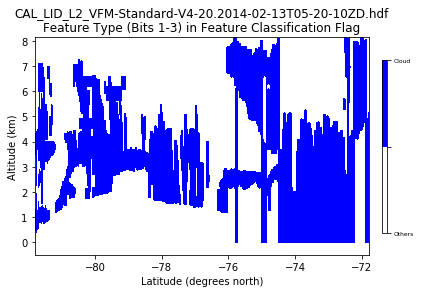

In [8]:
#!conda install -c conda-forge basemap --yes
"""
Copyright (C) 2014-2018 The HDF Group
Copyright (C) 2014 John Evans

This example code illustrates how to access and visualize a LaRC CALIPSO file 
in file in Python.

If you have any questions, suggestions, or comments on this example, please use
the HDF-EOS Forum (http://hdfeos.org/forums).  If you would like to see an
example of any other NASA HDF/HDF-EOS data product that is not listed in the
HDF-EOS Comprehensive Examples page (http://hdfeos.org/zoo), feel free to
contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum
(http://hdfeos.org/forums).

Usage:  save this script and run

    python CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf.v.py

The HDF file must be in your current working directory.

Tested under: Python 2.7.14 :: Anaconda custom (64-bit)
Last updated: 2018-05-22
"""
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyhdf.SD import SD, SDC
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

#FILE_NAME = 'CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf'
FILE_NAME = os.path.abspath(fname)
# Identify the data field.
DATAFIELD_NAME = 'Feature_Classification_Flags'

hdf = SD(FILE_NAME, SDC.READ)
        
# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:]

# Read geolocation datasets.
latitude = hdf.select('Latitude')
lat = latitude[:]
        

# Extract Feature Type only (1-3 bits) through bitmask.
data = data & 7

# Subset latitude values for the region of interest (40N to 62N).
# See the output of CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf.py example.
lat = lat[0:500]
size = lat.shape[0]
    
# You can visualize other blocks by changing subset parameters.
#  data2d = data[3500:3999, 0:164]    # 20.2km to 30.1km
#  data2d = data[3500:3999, 165:1164] #  8.2km to 20.2km

# data2d = data[3500:4000, 1165:]  # -0.5km to  8.2km
data2d = data[0:500, 1165:]  # -0.5km to  8.2km
data3d = np.reshape(data2d, (size, 15, 290))
data = data3d[:,0,:]

# Focus on cloud (=2) data only.
data[data > 2] = 0;
data[data < 2] = 0;
data[data == 2] = 1;

# Generate altitude data according to file specification [1].
alt = np.zeros(290)

# You can visualize other blocks by changing subset parameters.
#  20.2km to 30.1km
# for i in range (0, 54):
#       alt[i] = 20.2 + i*0.18;
#  8.2km to 20.2km
# for i in range (0, 199):
#       alt[i] = 8.2 + i*0.06;
# -0.5km to 8.2km
for i in range (0, 289):
    alt[i] = -0.5 + i*0.03

      
# Contour the data on a grid of latitude vs. pressure
latitude, altitude = np.meshgrid(lat, alt)


# Make a color map of fixed colors.
cmap = colors.ListedColormap(['white', 'blue', 'blue'])

# Define the bins and normalize.
bounds = np.linspace(0,2,3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


long_name = 'Feature Type (Bits 1-3) in Feature Classification Flag'
basename = os.path.basename(FILE_NAME)
plt.contourf(latitude, altitude, np.rot90(data,1), cmap=cmap)
plt.title('{0}\n{1}'.format(basename, long_name))
plt.xlabel('Latitude (degrees north)')
plt.ylabel('Altitude (km)')

fig = plt.gcf()

# Create a second axes for the discrete colorbar.
ax2 = fig.add_axes([0.93, 0.2, 0.01, 0.6])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, boundaries=bounds)
cb.ax.set_yticklabels(['Others','', 'Cloud'], fontsize=6)

# plt.show()
pngfile = "{0}.v.py.png".format(basename)
fig.savefig(pngfile)
    

 

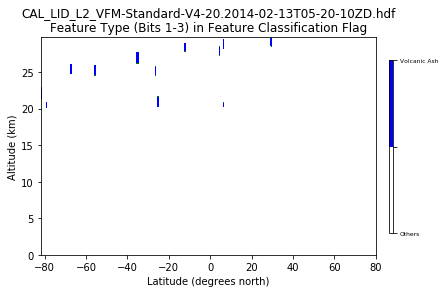

In [9]:
"""
Copyright (C) 2014-2018 The HDF Group
Copyright (C) 2014 John Evans

This example code illustrates how to access and visualize a LaRC CALIPSO file 
in file in Python.

If you have any questions, suggestions, or comments on this example, please use
the HDF-EOS Forum (http://hdfeos.org/forums).  If you would like to see an
example of any other NASA HDF/HDF-EOS data product that is not listed in the
HDF-EOS Comprehensive Examples page (http://hdfeos.org/zoo), feel free to
contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum
(http://hdfeos.org/forums).

Usage:  save this script and run

    python CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf.v.py

The HDF file must be in your current working directory.

Tested under: Python 2.7.14 :: Anaconda custom (64-bit)
Last updated: 2018-05-22
"""
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyhdf.SD import SD, SDC
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

#FILE_NAME = 'CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf'
FILE_NAME = os.path.abspath(fname)
# Identify the data field.
DATAFIELD_NAME = 'Feature_Classification_Flags'

hdf = SD(FILE_NAME, SDC.READ)
        
# Read dataset.
data2D = hdf.select(DATAFIELD_NAME)
data = data2D[:,:]

# Read geolocation datasets.
latitude = hdf.select('Latitude')
lat = latitude[:]
        

# Extract Feature Type only (1-3 bits) through bitmask.
#data = data & 7
# Extract Feature Type Stratospheric Aerosol = Volcanic Ash through bitmask.
data = data & np.uint16(0b0000010000000100)

# Subset latitude values for the region of interest (40N to 62N).
# See the output of CAL_LID_L2_VFM-ValStage1-V3-02.2011-12-31T23-18-11ZD.hdf.py example.
lat = lat[:]
size = lat.shape[0]
    
# You can visualize other blocks by changing subset parameters.
data2d = data[:, 0:165]    # 20.2km to 30.1km
data3d = np.reshape(data2d, (size, 3, 55))
#data2d = data[384:3971, 165:1165] #  8.2km to 20.2km
#data3d = np.reshape(data2d, (size, 5, 200))

# data2d = data[384:3971, 1165:]  # -0.5km to  8.2km
# data3d = np.reshape(data2d, (size, 15, 290))


data = data3d[:,0,:]

# Focus on volcanic ash (=4) data only.
#data[data > 4] = 0;
#data[data < 4] = 0;
#data[data == 4] = 1;

# Generate altitude data according to file specification [1].
#alt = np.zeros(290)
#alt = np.zeros(200)
alt = np.zeros(55)

# You can visualize other blocks by changing subset parameters.
#  20.2km to 30.1km
for i in range (0, 54):
    alt[i] = 20.2 + i*0.18;
#  8.2km to 20.2km
#for i in range (0, 199):
#    alt[i] = 8.2 + i*0.06;
# -0.5km to 8.2km
#for i in range (0, 289):
#    alt[i] = -0.5 + i*0.03

      
# Contour the data on a grid of latitude vs. pressure
latitude, altitude = np.meshgrid(lat, alt)


# Make a color map of fixed colors.
cmap = colors.ListedColormap(['white', 'green', 'blue'])

# Define the bins and normalize.
bounds = np.linspace(0,2,3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


long_name = 'Feature Type (Bits 1-3) in Feature Classification Flag'
basename = os.path.basename(FILE_NAME)
plt.contourf(latitude, altitude, np.rot90(data,1), cmap=cmap)
plt.title('{0}\n{1}'.format(basename, long_name))
plt.xlabel('Latitude (degrees north)')
plt.ylabel('Altitude (km)')

fig = plt.gcf()

# Create a second axes for the discrete colorbar.
ax2 = fig.add_axes([0.93, 0.2, 0.01, 0.6])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, boundaries=bounds)
cb.ax.set_yticklabels(['Others','', 'Volcanic Ash'], fontsize=6)

# plt.show()
pngfile = "{0}.v.py.png".format(basename)
fig.savefig(pngfile)
    

 

Retrieve Latitude, Longitude, Profile_Time, and Feature_Classification_Flags data arrays from a data granule in the CAL_LID_L2_VFM-Standard-V4-20 collection archived at the Atmospheric Science Data Center.


The browse imagery for this granule  can be found at the following url:
https://www-calipso.larc.nasa.gov/products/lidar/browse_images/show_detail.php?s=production&v=V4-10&browse_date=2014-02-13&orbit_time=05-20-10&granule_name=CAL_LID_L1-Standard-V4-10.2014-02-13T05-20-10ZD.hdf&page=2


But we only need four of the data arrays from this granule. We can request a subset of the original file by leveraging the pydap library.


(dim0 array index range: 2073-2517). Use the following dim0 filter for the OpenDAP subset: 2073:1:2517
bounding box footprint: POLYGON((114.0 -13.0,114.0 7.0,122.0 7.0,122.0 -13.0,114.0 -13.0))

https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2014/02/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.nc?Latitude[2073:1:2517][0:1:0],Longitude[2073:1:2517][0:1:0],Feature_Classification_Flags[2073:1:2517][0:1:5514]

In [10]:
import requests
import re

#find the dim0 stop
def gen_Feature_Classification_Flags_filter(opendap_url,dim1_range='[0:1165]'):
    content=requests.get(opendap_url+'.dds?Feature_Classification_Flags').content
    size=int(re.search('.*Feature_Classification_Flags\[fakeDim\d*\s?=\s?(\d*).*', str(content)).group(1))-1
    return 'Feature_Classification_Flags[0:' + str(size)+']' +dim1_range


#url='https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2014/02/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf'
#gen_Feature_Classification_Flags_filter(url)

In [12]:
from pydap.client import open_url
import numpy as np
from pyhdf.SD import SD, SDC
import requests
import os.path
import time

fname='CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf'
url='https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2014/02/CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf'




'''
start = time.time()
try:
    print("Attempting to download: "+fname+" from the ASDC OPeNDAP service...")
    r = requests.get(url, allow_redirects=True)
    open(fname, 'wb').write(r.content)
    if os.path.isfile(fname):
        print("Success! The full path to the data file is: "+os.path.abspath(fname))
except Exception as e:
    print("Error: " + str(e))
    
read_hdf = SD(fname, SDC.READ)

# Read datasets (arrays of data in the hdf4 file)
# Read geolocation datasets.
#selects for latitude
Feature_Classification_Flags = read_hdf.select('Feature_Classification_Flags')[:]
mask=np.uint16(0b0000010000000100)
volcanic_ash=Feature_Classification_Flags&mask
volcanic_ash_indices=np.where(volcanic_ash==mask)
end = time.time()
#(2, 4046) 5.0880279541015625 seconds to download and save entire CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf granule to disk
print(np.asarray(volcanic_ash_indices).shape,end - start,"seconds to download and save entire CAL_LID_L2_VFM-Standard-V4-20.2014-02-13T05-20-10ZD.hdf granule to disk")
print()
'''
outfile = open('opendap_stats.txt','a')
wktfile = open('CAL_LID_L2_VFM-Standard-V4-20.2019-01.wkt','a')
url_path='https://opendap.larc.nasa.gov:443/opendap/CALIPSO/LID_L2_VFM-Standard-V4-20/2019/01/'
params_list=['Latitude','Longitude','Profile_Time']
#params_list=[]
#params_list=['Feature_Classification_Flags[384:1:3972][0:1:5514]']


param_string = ",".join(params_list)

with open('/Users/wbaskin/git/test-CALIPSO/bin/CAL_LID_L2_VFM-Standard-V4-20.2019-01.txt', 'r') as f:
    for line_terminated in f:
        line = line_terminated.rstrip('\n')
        if line=='':
            continue
        
        url=url_path+line
        #param_string = ",".join(params_list)
        #param_string=param_string+','+gen_Feature_Classification_Flags_filter(url)
        
        #param_string=gen_Feature_Classification_Flags_filter(url,dim1_range='[0:165]')
        param_string=gen_Feature_Classification_Flags_filter(url)
        
        url=url+'?'+param_string
        
        start1 = time.time()
        dataset = open_url(url)
        end1 = time.time()
        start2 = time.time()
        od_Feature_Classification_Flags=dataset.Feature_Classification_Flags[:]
        end2 = time.time()
        #(4224, 5515) 11.640060186386108 seconds
        #(4224, 5515) 3.355064868927002 11.10647201538086 14.548460006713867 seconds Feature_Classification_Flags, Latitude
        #(4224, 5515) 2.5699751377105713 11.134072065353394 13.70406699180603 seconds Feature_Classification_Flags
        #(4224, 1166) 1.3209929466247559 3.9639711380004883 5.284983158111572 seconds Feature_Classification_Flags[0:1:4223][0:1:1165]
        #(4224, 1166) 1.4455251693725586 2.7000420093536377 4.1455841064453125 seconds Feature_Classification_Flags[0:1:4223][0:1:1165]
        #(4224, 166) 6.037283182144165 1.5829579830169678 7.620259046554565 seconds Feature_Classification_Flags[0:1:4223][0:1:165]
        #(4224, 166) 1.3240220546722412 0.9505090713500977 2.274549961090088 seconds Feature_Classification_Flags[0:1:4223][0:1:165]
        #from home
        #(4224, 166) 3.013113021850586 3.903203010559082 6.91633415222168 seconds Feature_Classification_Flags[0:1:4223][0:1:165]
        #(4224, 166) 2.8794989585876465 3.915311098098755 6.794828176498413 seconds Feature_Classification_Flags[0:1:4223][0:1:165]
        #(4224, 166) 2.4331982135772705 3.5491387844085693 5.982353925704956 seconds Feature_Classification_Flags[0:1:4223][0:1:165]
        mask=np.uint16(0b0000010000000100)
        volcanic_ash1=od_Feature_Classification_Flags&mask
        volcanic_ash_indices=np.where(volcanic_ash1==mask)
        end3 = time.time()
            
        print(np.asarray(od_Feature_Classification_Flags).shape, np.asarray(volcanic_ash_indices).shape,end1 - start1,end2-start2,end3-start1,"seconds ",line,param_string,file=outfile)
        print(np.asarray(od_Feature_Classification_Flags).shape, np.asarray(volcanic_ash_indices).shape,end1 - start1,end2-start2,end3-start1,"seconds ",line,param_string)  




wktfile.close()
outfile.close()
#print()
#print(np.asarray(volcanic_ash_indices).shape,end - start1, "seconds to identify volcanic ash indices")


AttributeError: 'NoneType' object has no attribute 'group'